In [4]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values



# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics
#!conda install -c districtdatalabs yellowbrick
#from yellowbrick.cluster import KElbowVisualizer

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [5]:
### Pull CSV data and observe categories

data_chi=pd.read_csv(r'C:/Users/schne/Desktop/IBM Data Science Certification/Python v2/Applied Data Science Capstone/Notebooks/Cities/Chicago/chicago_data.csv')
data_chi=data_chi.drop(columns='Unnamed: 0').reset_index(drop=True)


In [6]:
# Use Nominatim geocoder to get coodinates of Toronto
address = 'Chicago, USA'

geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

#print geocoordinates
print('The geograpical coordinate of Chicago, California are {}, {}.'.format(latitude, longitude))

# create map of Toronto using latitude and longitude values
map_chicago = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood, borough in zip(data_chi['Latitude'], data_chi['Longitude'], data_chi['Neighborhood'],data_chi['Borough']):
    label = '{}, {}'.format(neighborhood,borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

The geograpical coordinate of Chicago, California are 41.8755616, -87.6244212.


## Pull Foursquare Data using Rest API

In [7]:
### Open Foursquare Credentials
with open (r'C:\Users\schne\Desktop\IBM Data Science Certification\Python v2\Applied Data Science Capstone\fsquarecreds.json') as f:
    data = json.load(f)
    fsquare_creds = {'CLIENT_ID':data['CLIENT_ID'],'CLIENT_SECRET':data['CLIENT_SECRET'],'VERSION':data['VERSION']}

In [8]:
#Define function to get nearby venues based on Neighborhood Lat/Lng

limit = 100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            fsquare_creds['CLIENT_ID'], 
            fsquare_creds['CLIENT_SECRET'], 
            fsquare_creds['VERSION'], 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#code to run the above function on each neighborhood and create a new dataframe called *df_venues*

data_chi_venues = getNearbyVenues(names=data_chi['Neighborhood'],
                                   latitudes=data_chi['Latitude'],
                                   longitudes=data_chi['Longitude'])



Greektown
Printers Row
Millenium Park
Rush & Division
Magnificent Mile
Boystown
East Village
Wrigleyville
Andersonville
Grant Park
Sheffield & DePaul
Ukrainian Village
Gold Coast
Chinatown
Old Town
Burnside
Oakland
Wicker Park
Montclare
United Center
Kenwood
Armour Square
Galewood
Fuller Park
Mckinley Park
Edison Park
Bucktown
West Elsdon
Near South Side
Hermosa
Avalon Park
Hyde Park
Washington Park
Grand Boulevard
Woodlawn
Douglas
Edgewater
North Center
River North
Archer Heights
Gage Park
Bridgeport
Jackson Park
Calumet Heights
Rogers Park
Avondale
Museum Campus
Pullman
Logan Square
Brighton Park
Little Italy, UIC
Lincoln Square
Albany Park
Chicago Lawn
Streeterville
North Park
West Lawn
Chatham
Washington Heights
West Ridge
Lower West Side
Belmont Cragin
West Loop
Jefferson Park
South Shore
Garfield Park
Beverly
North Lawndale
Clearing
Humboldt Park
Morgan Park
Riverdale
Portage Park
Auburn Gresham
West Town
Uptown
New City
Mount Greenwood
Irving Park
West Pullman
Little Village
Eas

In [9]:
#Print shape of dataframe and show head
print(data_chi_venues.shape)
print(data_chi_venues.head())
print(len(data_chi_venues['Neighborhood'].unique()))

(2745, 7)
  Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Greektown              41.878545              -87.647127   
1    Greektown              41.878545              -87.647127   
2    Greektown              41.878545              -87.647127   
3    Greektown              41.878545              -87.647127   
4    Greektown              41.878545              -87.647127   

                                 Venue  Venue Latitude  Venue Longitude  \
0                               H-Mart       41.877857       -87.644980   
1                        Greek Islands       41.878922       -87.647328   
2               Mariano's Fresh Market       41.880802       -87.647751   
3                   SGD DUBU - @h mart       41.877813       -87.644876   
4  TITLE Boxing Club Chicago West Loop       41.877563       -87.649463   

      Venue Category  
0      Grocery Store  
1   Greek Restaurant  
2      Grocery Store  
3  Korean Restaurant  
4         Boxing Gym  
96


Let's check how many venues were returned for each neighborhood. Let's also look at the number of unqiue venue categories

In [10]:
## Number of Venues for each Neighborhood
print(data_chi_venues.groupby('Neighborhood').count().head())

##Check number of Neighborhoods 
print('There are {} unique Neighborhoods.'.format(len(data_chi_venues['Neighborhood'].unique())))

## Number of Unique Categoriges
print('There are {} unique categories.'.format(len(data_chi_venues['Venue Category'].unique())))

                Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                           
Albany Park                        17                      17     17   
Andersonville                      53                      53     53   
Archer Heights                     17                      17     17   
Armour Square                      22                      22     22   
Ashburn                             4                       4      4   

                Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                     
Albany Park                 17               17              17  
Andersonville               53               53              53  
Archer Heights              17               17              17  
Armour Square               22               22              22  
Ashburn                      4                4               4  
There are 96 unique Neighborhoods

### Format Data for K-Means Clustering

In [11]:
# one hot encoding
data_chi_onehot = pd.get_dummies(data_chi_venues['Venue Category'], prefix="", prefix_sep=" ")

# add neighborhood column back to dataframe
data_chi_onehot['Neighborhood'] = data_chi_venues['Neighborhood'] 
data_chi_onehot.head()

# move neighborhood column to the first column
fixed_columns = [data_chi_onehot.columns[-1]] + list(data_chi_onehot.columns[:-1])
print(fixed_columns)

data_chi_onehot = data_chi_onehot[fixed_columns]
data_chi_onehot.head()
print(data_chi_onehot.shape)
data_chi_grouped = data_chi_onehot.groupby('Neighborhood').mean().reset_index()
data_chi_grouped.head()

['Neighborhood', ' ATM', ' Accessories Store', ' African Restaurant', ' Airport Lounge', ' Airport Service', ' Airport Terminal', ' American Restaurant', ' Amphitheater', ' Antique Shop', ' Aquarium', ' Arcade', ' Arepa Restaurant', ' Argentinian Restaurant', ' Art Gallery', ' Art Museum', ' Arts & Crafts Store', ' Arts & Entertainment', ' Asian Restaurant', ' Athletics & Sports', ' Auditorium', ' Auto Garage', ' Automotive Shop', ' BBQ Joint', ' Bagel Shop', ' Bakery', ' Bank', ' Bar', ' Baseball Field', ' Baseball Stadium', ' Basketball Court', ' Basketball Stadium', ' Beach', ' Bed & Breakfast', ' Beer Bar', ' Beer Garden', ' Big Box Store', ' Bike Rental / Bike Share', ' Bike Trail', ' Bistro', ' Board Shop', ' Boat or Ferry', ' Bookstore', ' Boutique', ' Bowling Alley', ' Boxing Gym', ' Brazilian Restaurant', ' Breakfast Spot', ' Brewery', ' Bridal Shop', ' Bridge', ' Bubble Tea Shop', ' Building', ' Burger Joint', ' Burrito Place', ' Bus Line', ' Bus Station', ' Business Service'

,Neighborhood,ATM,Accessories Store,African Restaurant,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Rec Center,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Currency Exchange,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fishing Spot,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Night Market,Nightclub,Non-Profit,Noodle House,Office,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Pub,Public Art,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Rest Area,Restaurant,Road,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,State / Provincial Park,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Sze

In [12]:
#Function to grab the top 5 venues in a dataframe
num_top_venues = 5

for hood in data_chi_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = data_chi_grouped[data_chi_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Albany Park----
                        venue  freq
0          Mexican Restaurant  0.24
1   Latin American Restaurant  0.06
2                      Bakery  0.06
3          Seafood Restaurant  0.06
4               Grocery Store  0.06


----Andersonville----
               venue  freq
0        Coffee Shop  0.06
1      Grocery Store  0.04
2   Sushi Restaurant  0.04
3             Bakery  0.04
4             Lounge  0.04


----Archer Heights----
                 venue  freq
0   Mexican Restaurant  0.18
1        Grocery Store  0.12
2        Big Box Store  0.06
3          Video Store  0.06
4                 Bank  0.06


----Armour Square----
                   venue  freq
0                    Bar  0.09
1   Fast Food Restaurant  0.05
2                    Gym  0.05
3         Sandwich Place  0.05
4                   Park  0.05


----Ashburn----
                    venue  freq
0         Automotive Shop  0.25
1          Cosmetics Shop  0.25
2      Light Rail Station  0.25
3             Pizza Pla

4                   ATM  0.00


----Sheffield & DePaul----
          venue  freq
0   Coffee Shop  0.10
1       Theater  0.05
2   Music Venue  0.05
3   Pizza Place  0.05
4          Park  0.05


----South Chicago----
            venue  freq
0            Park   0.2
1   Train Station   0.2
2    Burger Joint   0.1
3            Food   0.1
4   Grocery Store   0.1


----South Deering----
                   venue  freq
0             Bike Trail   1.0
1                    ATM   0.0
2   Other Great Outdoors   0.0
3                Parking   0.0
4                   Park   0.0


----South Shore----
               venue  freq
0         Nail Salon  0.06
1   Video Game Store  0.06
2     Discount Store  0.06
3        Pizza Place  0.06
4     Sandwich Place  0.06


----Streeterville----
                      venue  freq
0                     Hotel  0.06
1               Coffee Shop  0.06
2            Breakfast Spot  0.05
3            Sandwich Place  0.04
4   New American Restaurant  0.04


----Ukrainian Vil

In [23]:
    
# function to return most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#grab the top 10 venues

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
columns

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = data_chi_grouped['Neighborhood']

#add common venues into new dataframe
for ind in np.arange(data_chi_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(data_chi_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany Park,Mexican Restaurant,Chinese Restaurant,Karaoke Bar,Grocery Store,Park,Seafood Restaurant,Latin American Restaurant,Asian Restaurant,Korean Restaurant,Taco Place
1,Andersonville,Coffee Shop,Sushi Restaurant,Lounge,Bakery,Café,Grocery Store,Middle Eastern Restaurant,Breakfast Spot,Miscellaneous Shop,Shoe Store
2,Archer Heights,Mexican Restaurant,Grocery Store,Sandwich Place,Bank,Bar,Seafood Restaurant,Park,Gas Station,Pharmacy,Video Store
3,Armour Square,Bar,Bagel Shop,Coffee Shop,Sporting Goods Shop,Fast Food Restaurant,Bus Station,Gas Station,Café,Sandwich Place,Baseball Stadium
4,Ashburn,Pizza Place,Cosmetics Shop,Light Rail Station,Automotive Shop,Zoo Exhibit,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm


## K-Means Clustering

### Check for Optimal K (elbow Method)

In [24]:
# Remove column 'Neighborhood' from grouped data
data_chi_grouped_clustering = data_chi_grouped.drop('Neighborhood', 1)

# Instantiate the clustering model and visualizer
model = KMeans().fit(data_chi_grouped_clustering)
#visualizer = KElbowVisualizer(model, k=(1,10))

#visualizer.fit(data_chi_grouped_clustering)        # Fit the data to the visualizer
#visualizer.show() 

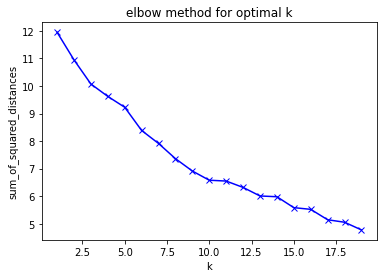

In [105]:
sum_of_squared_distances = []
K = range(1,20)
for k in K:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(data_chi_grouped_clustering)
    sum_of_squared_distances.append(k_means.inertia_)

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('elbow method for optimal k')
plt.show()

#### Elbow method isn't appreaing to be to accurate, so let's go with 5, the same number used in the New York dataset. exponential nature of distortion makes for suspect of validity of using K-Means Clustinger

In [106]:
# set number of clusters
kclusters = 10

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters,random_state=0).fit(data_chi_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:6] 

# add clustering labels #Comment this cell when run
neighborhoods_venues_sorted=neighborhoods_venues_sorted.drop(columns='Cluster Labels')
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,5,Albany Park,Mexican Restaurant,Chinese Restaurant,Karaoke Bar,Grocery Store,Park,Seafood Restaurant,Latin American Restaurant,Asian Restaurant,Korean Restaurant,Taco Place
1,2,Andersonville,Coffee Shop,Sushi Restaurant,Lounge,Bakery,Café,Grocery Store,Middle Eastern Restaurant,Breakfast Spot,Miscellaneous Shop,Shoe Store
2,5,Archer Heights,Mexican Restaurant,Grocery Store,Sandwich Place,Bank,Bar,Seafood Restaurant,Park,Gas Station,Pharmacy,Video Store
3,2,Armour Square,Bar,Bagel Shop,Coffee Shop,Sporting Goods Shop,Fast Food Restaurant,Bus Station,Gas Station,Café,Sandwich Place,Baseball Stadium
4,2,Ashburn,Pizza Place,Cosmetics Shop,Light Rail Station,Automotive Shop,Zoo Exhibit,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm


In [107]:

# merge toronto_grouped with data_chi to add latitude/longitude for each neighborhood
data_chi_merged = data_chi

data_chi_merged = data_chi_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# check the last columns!
print(data_chi_merged.shape)
data_chi_merged.tail()

(98, 15)


,Neighborhood,Borough,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
93,Hegewisch,SOUTHEAST SIDE,-87.540715,41.663671,4.0,State / Provincial Park,Fishing Spot,Field,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
94,"Sauganash,Forest Glen","SAUGANASH,FOREST GLEN",-87.758356,41.993931,1.0,Sports Bar,Moving Target,American Restaurant,Golf Course,Field,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market
95,South Deering,SOUTHEAST SIDE,-87.570057,41.690637,3.0,Bike Trail,Filipino Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop
96,Norwood Park,NORWOOD PARK,-87.804531,41.985015,5.0,Bar,Park,Pharmacy,Flower Shop,Bus Station,Chinese Restaurant,Mexican Restaurant,Road,Café,Ethiopian Restaurant
97,O'Hare,OHARE,-87.913647,41.980240,2.0,Coffee Shop,Snack Place,Airport Lounge,American Restaurant,Hot Dog Joint,Pizza Place,Electronics Store,Seafood Restaurant,Burger Joint,Salad Place


In [108]:
#Remove N/A Values
print(data_chi_merged.shape)

data_chi_merged=data_chi_merged.dropna()
print(data_chi_merged.shape)

# check the data type
data_chi_merged['Cluster Labels']=data_chi_merged['Cluster Labels'].astype(int)

(98, 15)
(96, 15)


In [109]:
data_chi_merged.dtypes

Neighborhood               object
Borough                    object
Longitude                 float64
Latitude                  float64
Cluster Labels              int32
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

In [110]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(data_chi_merged['Latitude'], data_chi_merged['Longitude'], data_chi_merged['Neighborhood'], data_chi_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' : Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Cluster 1

In [111]:
data_chi_merged.loc[data_chi_merged['Cluster Labels'] == 0, data_chi_merged.columns[[0]  + list(range(5, data_chi_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Galewood,Currency Exchange,Hotel,Zoo Exhibit,Field,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market
84,Grand Crossing,Currency Exchange,Fast Food Restaurant,Lounge,Convenience Store,Spa,Chinese Restaurant,Liquor Store,Event Space,Eye Doctor,Falafel Restaurant


# Cluster 2

In [112]:
data_chi_merged.loc[data_chi_merged['Cluster Labels'] == 1, data_chi_merged.columns[[0]  + list(range(5, data_chi_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Montclare,Fast Food Restaurant,Convenience Store,Wings Joint,Bar,Pizza Place,Zoo Exhibit,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant
72,Portage Park,Ice Cream Shop,Dog Run,Mexican Restaurant,Sports Bar,Pizza Place,Nightclub,Gym Pool,Pet Store,Sushi Restaurant,Farmers Market
94,"Sauganash,Forest Glen",Sports Bar,Moving Target,American Restaurant,Golf Course,Field,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market


# Cluster 3

In [113]:
data_chi_merged.loc[data_chi_merged['Cluster Labels'] == 2, data_chi_merged.columns[[0]  + list(range(5, data_chi_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Greektown,Greek Restaurant,Coffee Shop,Café,Grocery Store,Breakfast Spot,Convenience Store,Pizza Place,Gym,Dog Run,Park
1,Printers Row,Gym / Fitness Center,Pizza Place,Hotel,Clothing Store,Tapas Restaurant,Indian Restaurant,Coffee Shop,Taco Place,Burger Joint,American Restaurant
2,Millenium Park,Coffee Shop,Park,Hotel,American Restaurant,Pizza Place,Boat or Ferry,Pharmacy,Museum,Train Station,Italian Restaurant
3,Rush & Division,American Restaurant,Hotel,Coffee Shop,Steakhouse,Italian Restaurant,Clothing Store,New American Restaurant,Café,Boutique,Bar
4,Magnificent Mile,Hotel,American Restaurant,New American Restaurant,Department Store,Donut Shop,Pizza Place,Italian Restaurant,Restaurant,Clothing Store,Chocolate Shop
5,Boystown,Gay Bar,Sushi Restaurant,Mexican Restaurant,Coffee Shop,Spa,Japanese Restaurant,Dive Bar,BBQ Joint,Pizza Place,Café
6,East Village,Mexican Restaurant,Pizza Place,Café,Bar,Greek Restaurant,Bakery,Coffee Shop,Optical Shop,Gym,Clothing Store
7,Wrigleyville,Sports Bar,Ice Cream Shop,General Entertainment,Pizza Place,Bar,Taco Place,Baseball Stadium,New American Restaurant,Coffee Shop,Empanada Restaurant
8,Andersonville,Coffee Shop,Sushi Restaurant,Lounge,Bakery,Café,Grocery Store,Middle Eastern Restaurant,Breakfast Spot,Miscellaneous Shop,Shoe Store
9,Grant Park,Music Venue,Boat or Ferry,Hotel,Ice Cream Shop,Harbor / Marina,Trail,Escape Room,Garden,Liquor Store,Fried Chicken Joint


# Cluster 4

In [114]:
data_chi_merged.loc[data_chi_merged['Cluster Labels'] == 3, data_chi_merged.columns[[0]  + list(range(5, data_chi_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
95,South Deering,Bike Trail,Filipino Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop


# Cluster 5

In [115]:
data_chi_merged.loc[data_chi_merged['Cluster Labels'] == 4, data_chi_merged.columns[[0]  + list(range(5, data_chi_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
93,Hegewisch,State / Provincial Park,Fishing Spot,Field,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant


# Cluster 6

In [116]:
data_chi_merged.loc[data_chi_merged['Cluster Labels'] == 5, data_chi_merged.columns[[0]  + list(range(5, data_chi_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Mckinley Park,Diner,Video Store,Video Game Store,Grocery Store,Burger Joint,Chinese Restaurant,Gas Station,Pharmacy,Discount Store,Seafood Restaurant
25,Edison Park,Theater,Athletics & Sports,Neighborhood,Mexican Restaurant,Park,Farmers Market,Escape Room,Ethiopian Restaurant,Event Space,Eye Doctor
27,West Elsdon,Mexican Restaurant,Fried Chicken Joint,Rental Service,Bar,Donut Shop,Fast Food Restaurant,Video Store,Gas Station,Supermarket,American Restaurant
29,Hermosa,Park,Mexican Restaurant,BBQ Joint,Arcade,Bakery,Auto Garage,Latin American Restaurant,Bus Station,Grocery Store,Historic Site
39,Archer Heights,Mexican Restaurant,Grocery Store,Sandwich Place,Bank,Bar,Seafood Restaurant,Park,Gas Station,Pharmacy,Video Store
40,Gage Park,Mexican Restaurant,Sporting Goods Shop,Convenience Store,Bakery,Asian Restaurant,Sandwich Place,Zoo Exhibit,Fast Food Restaurant,Eye Doctor,Falafel Restaurant
44,Rogers Park,Mexican Restaurant,Theater,Pizza Place,American Restaurant,Bakery,Donut Shop,Train Station,Chinese Restaurant,Bar,Park
49,Brighton Park,Mexican Restaurant,Grocery Store,Taco Place,Pizza Place,Burger Joint,Breakfast Spot,Park,Bus Station,Café,Arts & Crafts Store
52,Albany Park,Mexican Restaurant,Chinese Restaurant,Karaoke Bar,Grocery Store,Park,Seafood Restaurant,Latin American Restaurant,Asian Restaurant,Korean Restaurant,Taco Place
56,West Lawn,Mexican Restaurant,Ice Cream Shop,Seafood Restaurant,Laundromat,Pizza Place,Diner,Donut Shop,Park,Shopping Mall,Fast Food Restaurant


# Cluster 7

In [117]:
data_chi_merged.loc[data_chi_merged['Cluster Labels'] == 6, data_chi_merged.columns[[0]  + list(range(5, data_chi_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
43,Calumet Heights,Gym / Fitness Center,Fast Food Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Zoo Exhibit


# Cluster 8

In [118]:
data_chi_merged.loc[data_chi_merged['Cluster Labels'] == 7, data_chi_merged.columns[[0]  + list(range(5, data_chi_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
67,North Lawndale,BBQ Joint,Convenience Store,Zoo Exhibit,Field,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant


# Cluster 9

In [119]:
data_chi_merged.loc[data_chi_merged['Cluster Labels'] == 4, data_chi_merged.columns[[0]  + list(range(5, data_chi_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
93,Hegewisch,State / Provincial Park,Fishing Spot,Field,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant


# Cluster 10

In [120]:
data_chi_merged.loc[data_chi_merged['Cluster Labels'] == 4, data_chi_merged.columns[[0]  + list(range(5, data_chi_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
93,Hegewisch,State / Provincial Park,Fishing Spot,Field,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
